# Epidemics

Demonstration for Large Scale Distributed Systems.

## Simulator

Each infectious element *i* of the population randomly selects *f* other distinct elements of the population:

In [1]:
import random
def sampler(n,f):
    p = [ j for j in range(n-1) ]
    return lambda i: [ j if j<i else j+1 for j in random.sample(p, f) ]

In a round, each element *i* infected in a previous round (1) selects and tries to infect each *j* from a random sample of the population, if *j* has not been infected before and is susceptible (0). The round indicates if any new member has been infected, as otherwise the run has ended. Each *i* is then marked as recovered (2).

In [2]:
def round(p,x,v):
    np = p.copy()
    chg = False
    for i,s in enumerate(p):
        if s==1:
            np[i] = 2
            for j in x(i):
                v[j] += 1
                if np[j] == 0:
                    np[j] = 1
            chg = True
    return np,chg

A simulation run starts with a single random member of the population infected (1) and performs rounds while the state of the population is changing.

In [3]:
def run(n,f):
    x = sampler(n,f)
    p = [0]*n
    v = [0]*n
    p[random.randint(0,n-1)] = 1
    chg = True
    while chg:
        p,chg = round(p,x,v)
    return v

## Run

We run *P* iterations for each fanout *1 <= f <= F* with a population o *N* members.

In [4]:
N = 200
F = 13

P = 100

data = [ (f, i, j, 1 if j>0 else 0) for f in range(1,F) for i in range(P) for j in run(N,f) ]

In the data analysis we compute:
* the mean number of infections for each fanout value
* the number of iterations with complete infections, for each fanout value

In [5]:
import pandas as pd

raw = pd.DataFrame(data, columns=['fanout','iter','value','infected'])

meaninf = raw.groupby('fanout').agg({'infected': 'mean'})

byiter = (raw.loc[raw['infected'] == 1].groupby(['fanout','iter']).size()/N).to_frame(name='del')
meanatom = (byiter.loc[byiter['del'] == 1.0].groupby('fanout').size()/P).to_frame(name='atomic')

result = meaninf.join(meanatom)

The result can be compared to the expected probability of complete infection.

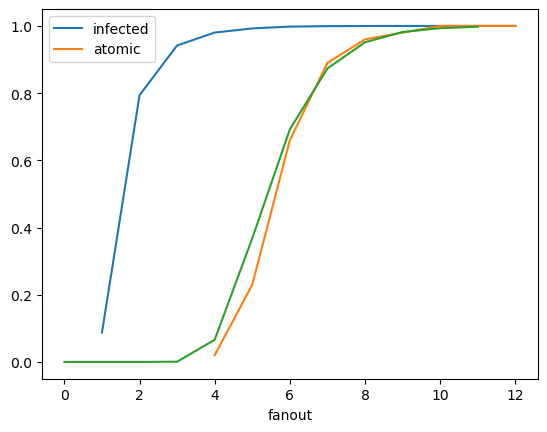

In [6]:
import numpy as np
from math import log
import matplotlib.pyplot as plt

x = np.array(range(12))
y = np.exp(-np.exp(-(x-int(log(N)))))

result.plot()
plt.plot(x,y)

Finally, we count the number of times each node is in contact with a an infected member.

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>],
       [<AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>]], dtype=object)

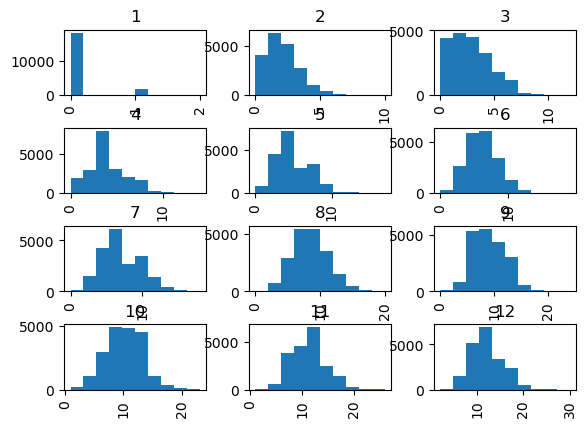

In [7]:
raw.hist(column='value', by='fanout')